In [154]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import zipfile

Добавляем датасет с помощью монтирования гугл диска (не придется качать данные и датасеты быстро сами на стороне гугла загрузятся за мгновения)

In [155]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [156]:
zip_file = '/content/drive/MyDrive/data/rrts(labels).zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall('/content/dataset1')

In [157]:
data_dir = '../content/dataset1/rrts/RoadSigns/'
train_dir = '../content/dataset1/rrts/RoadSigns/trainRoadSign/'
test_dir = '../content/dataset1/rrts/RoadSigns/testRoadSign/'

batch_size = 32
epochs = 20
num_classes = 37
img_height, img_width = 32, 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

Found 4932 images belonging to 37 classes.


Text(0, 0.5, 'Number of images')

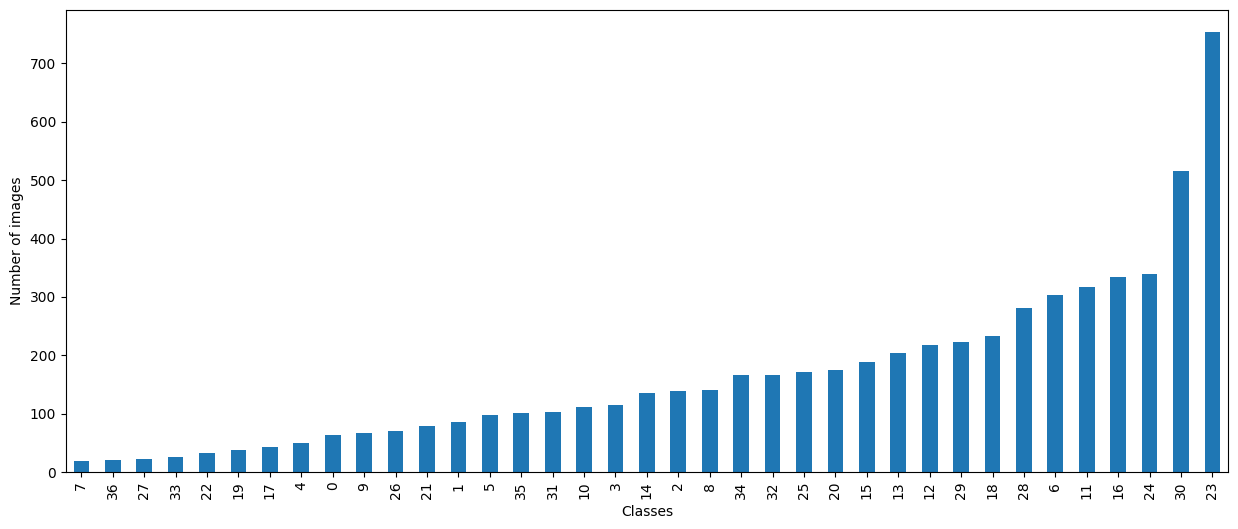

In [158]:
data_dic = {}
for folder in os.listdir(train_dir):
    data_dic[folder] = len(os.listdir(train_dir + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Classes')
plt.ylabel('Number of images')

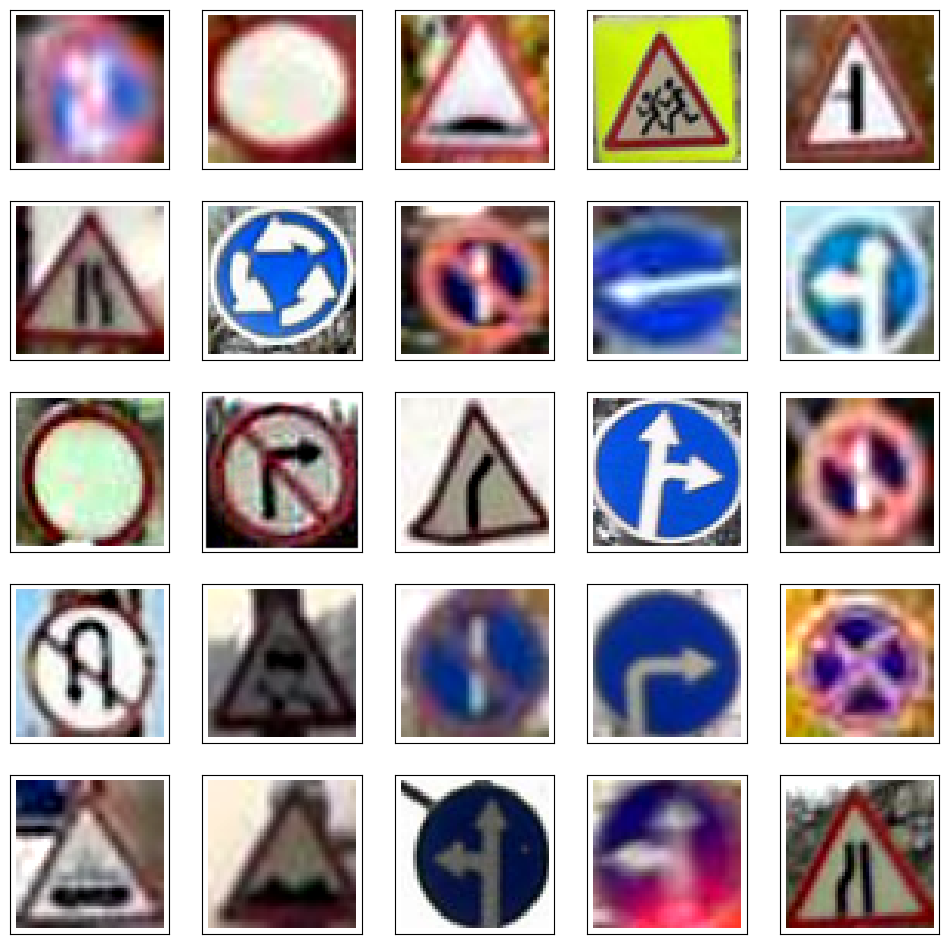

In [159]:
import os
import random
from PIL import Image



fig, axs = plt.subplots(5, 5, figsize=(12, 12))

for i in range(25):
    class_dir = os.path.join(train_dir, str(random.randint(0, 36)))
    img_path = os.path.join(class_dir, random.choice(os.listdir(class_dir)))
    img = Image.open(img_path)

    row = i // 5
    col = i % 5
    pad_width = 2

    padded_img = Image.new(mode='RGB', size=(img.width + (2 * pad_width), img.height + (2 * pad_width)), color='white')
    padded_img.paste(img, (pad_width, pad_width))

    axs[row][col].imshow(padded_img)
    axs[row][col].set_xticks([])
    axs[row][col].set_yticks([])
    axs[row][col].grid(color='black', linestyle='-', linewidth=2)

plt.show()

In [160]:

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 1212 images belonging to 37 classes.
Found 1449 images belonging to 37 classes.


In [161]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten,
    Conv2D, MaxPooling2D
)
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same',
                        input_shape=(img_height, img_width, 3)),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same'),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3)),
    keras.layers.Activation('relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(units=num_classes, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [162]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_9 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 15, 15, 32)        0         
                                                      

In [163]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size)


Epoch 1/20
154/154 [==============================] - 33s 199ms/step - loss: 1.9448 - accuracy: 0.4986 - val_loss: 0.5755 - val_accuracy: 0.8514
Epoch 2/20
154/154 [==============================] - 29s 190ms/step - loss: 0.4707 - accuracy: 0.8629 - val_loss: 0.2553 - val_accuracy: 0.9367
Epoch 3/20
154/154 [==============================] - 33s 207ms/step - loss: 0.2041 - accuracy: 0.9427 - val_loss: 0.1901 - val_accuracy: 0.9603
Epoch 4/20
154/154 [==============================] - 29s 190ms/step - loss: 0.1406 - accuracy: 0.9571 - val_loss: 0.1911 - val_accuracy: 0.9527
Epoch 5/20
154/154 [==============================] - 31s 199ms/step - loss: 0.0974 - accuracy: 0.9702 - val_loss: 0.1521 - val_accuracy: 0.9645
Epoch 6/20
154/154 [==============================] - 32s 208ms/step - loss: 0.0705 - accuracy: 0.9780 - val_loss: 0.1224 - val_accuracy: 0.9721
Epoch 7/20
154/154 [==============================] - 44s 290ms/step - loss: 0.0595 - accuracy: 0.9812 - val_loss: 0.1475 - val_ac

Text(0.5, 1.0, 'Loss')

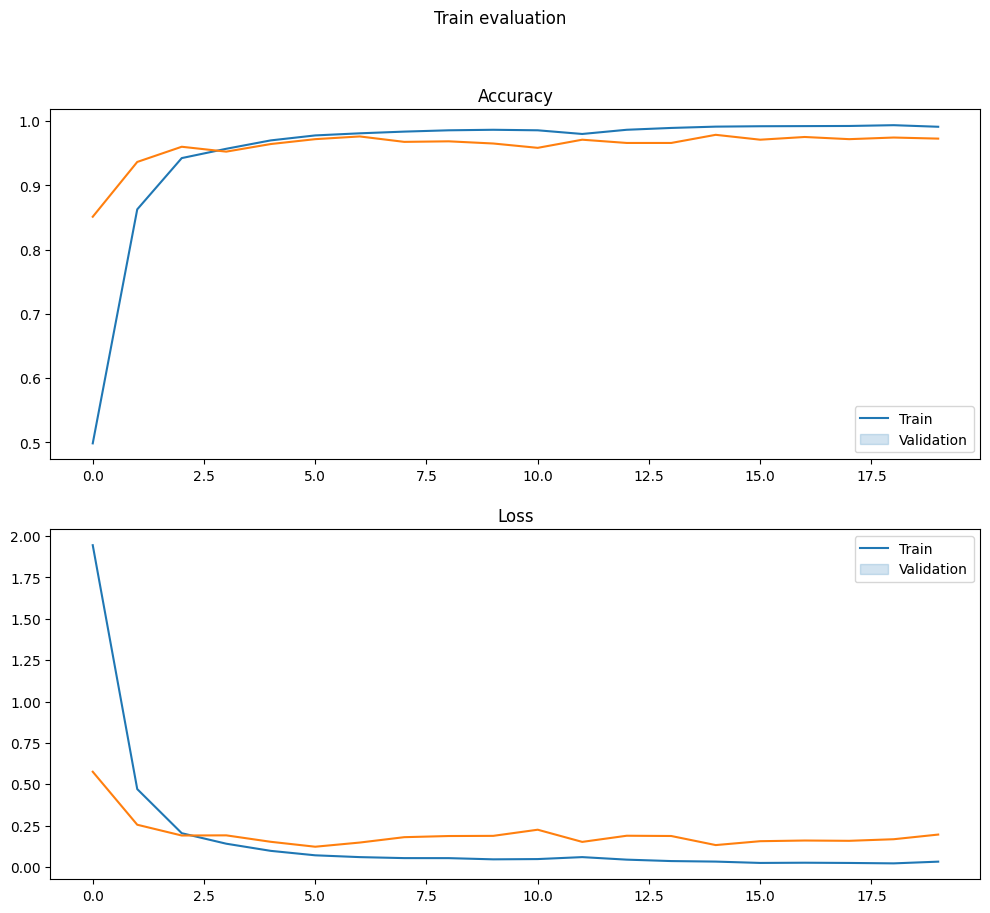

In [164]:
import seaborn as sns
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')

In [165]:
y_pred = model.predict(validation_generator, validation_generator.n//validation_generator.batch_size+1)

# Получаем метрики модели
score = model.evaluate(validation_generator, verbose=0)

# Выводим отчет о метриках модели
print('Test loss:', score[0])
print('Test accuracy:', score[1])


38/38 [==============================] - 2s 44ms/step
Test loss: 0.1913347840309143
Test accuracy: 0.9735973477363586


In [166]:
# class_description_dict = {
#     0: 'Пересечение с трамвайной линией',
#     1:'Опасный поворот 1.11',
#     2:'Опасный поворот 1.12',
#     3:'Опасные повороты',
#     4:'Скользкая дорога',
#     5:'Неровная дорога',
#     6:'Искусственная неровность',
#     7:'Сужение дороги 1.18.1',
#     8:'Сужение дороги 1.18.2',
#     9:'Сужение дороги 1.18.3',
#     10:'Предупредающий знак "пешеходный переход"',
#     11:'Дети',
#     12:'Дорожные работы',
#     13:'Примыкание второстепенной дороги 2.3.2',
#     14:'Примыкание второстепенной дороги 2.3.3',
#     15:'Движение без остановки запрещено',
#     16:'Въезд запрещен',
#     17:'Движение запрещено',
#     18:'Движение грузовых автомобилей запрещено',
#     19:'Ограничение высоты',
#     20:'Поворот направо запрещен',
#     21:'Поворот налево запрещен',
#     22:'Разворот запрещен',
#     23:'Ограничение максимальной скорости',
#     24:'Остановка запрещена',
#     25:'Стоянка запрещена',
#     26:'Стоянка запрещена по нечетным числам месяца',
#     27:'Стоянка запрещена по четным числам месяца',
#     28:'Движение прямо',
#     29:'Движение направо',
#     30:'Движение прямо или направо',
#     31:'Движение прямо или налево',
#     32:'Объезд препятствия справа',
#     33:'Объезд препятствия слева',
#     34:'Объезд препятствия справа или слева',
#     35:'Круговое движение',
#     36:'Пешеходный переход'
# }

# def get_value(d, key):
#     for k, v in d.items():
#         if k == key:
#             return v

Предсказание знаков. Номера классов присвоены так, как это сделано в папке с тренировочными данными (trainRoadSign)

In [186]:
# images, labels = next(validation_generator)
# class_names = list(validation_generator.class_indices.keys())
# y_pred = model.predict(images)


# colors = ['green' if np.argmax(y)==np.argmax(y_pred[i]) else 'red' for i,y in enumerate(labels)]

# plt.figure(figsize=(16, 16))

# for i in range(len(images)):
#     plt.subplot(16, 2, i+1)
#     plt.imshow(images[i])
#     plt.axis('off')
#     l = class_names[np.argmax(labels[i])]
#     plt.title(l  + " - " + str(get_value(class_description_dict, int(l))), color='black')
#     plt.subplots_adjust(hspace=0.5)
#     plt.subplots_adjust(wspace=0.5)
# plt.show()


1/1 [==============================] - 0s 50ms/step


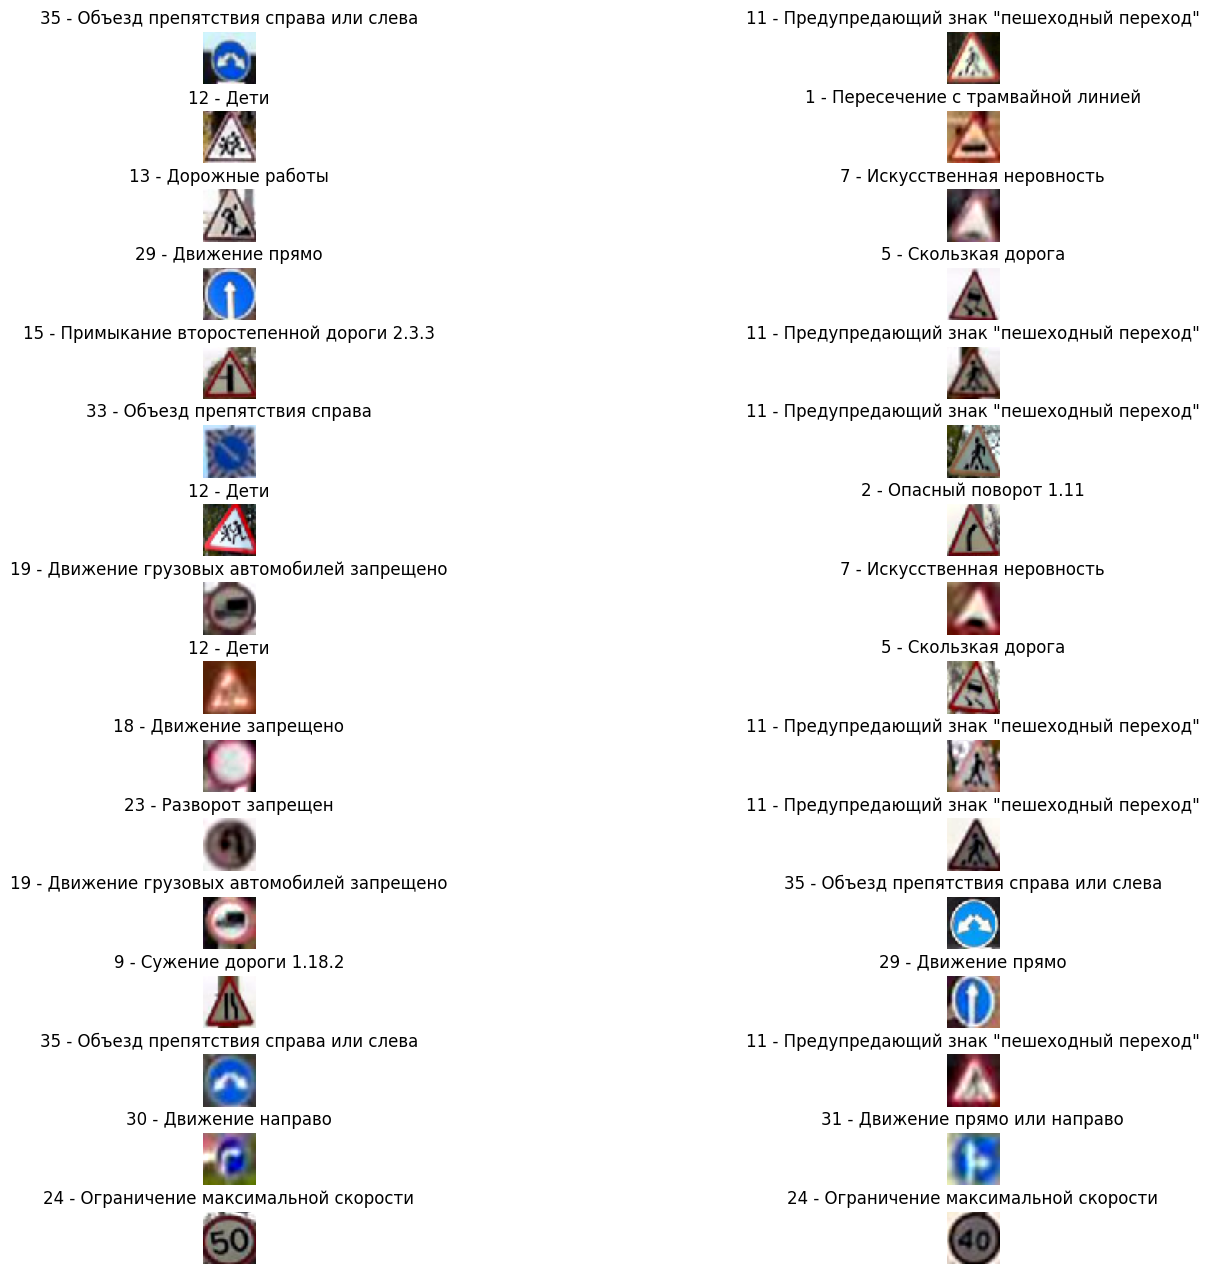

24


In [194]:
#  изменил лейблы на 1 сдвинул не с0 до 36 а с 1 до 37 для тестовой выборки
class_description_dict = {
    1: 'Пересечение с трамвайной линией',
    2:'Опасный поворот 1.11',
    3:'Опасный поворот 1.12',
    4:'Опасные повороты',
    5:'Скользкая дорога',
    6:'Неровная дорога',
    7:'Искусственная неровность',
    8:'Сужение дороги 1.18.1',
    9:'Сужение дороги 1.18.2',
    10:'Сужение дороги 1.18.3',
    11:'Предупредающий знак "пешеходный переход"',
    12:'Дети',
    13:'Дорожные работы',
    14:'Примыкание второстепенной дороги 2.3.2',
    15:'Примыкание второстепенной дороги 2.3.3',
    16:'Движение без остановки запрещено',
    17:'Въезд запрещен',
    18:'Движение запрещено',
    19:'Движение грузовых автомобилей запрещено',
    20:'Ограничение высоты',
    21:'Поворот направо запрещен',
    22:'Поворот налево запрещен',
    23:'Разворот запрещен',
    24:'Ограничение максимальной скорости',
    25:'Остановка запрещена',
    26:'Стоянка запрещена',
    27:'Стоянка запрещена по нечетным числам месяца',
    28:'Стоянка запрещена по четным числам месяца',
    29:'Движение прямо',
    30:'Движение направо',
    31:'Движение прямо или направо',
    32:'Движение прямо или налево',
    33:'Объезд препятствия справа',
    34:'Объезд препятствия слева',
    35:'Объезд препятствия справа или слева',
    36:'Круговое движение',
    37:'Пешеходный переход'
}
def get_value(d, key):
    for k, v in d.items():
        if k == key:
            return v
# test_generator
images, labels = next(test_generator)
class_names = list(test_generator.class_indices.keys())
y_pred = model.predict(images)


colors = ['green' if np.argmax(y)==np.argmax(y_pred[i]) else 'red' for i,y in enumerate(labels)]

plt.figure(figsize=(16, 16))

for i in range(len(images)):
    plt.subplot(16, 2, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    l = class_names[np.argmax(labels[i])]
    plt.title(str(int(l))  + " - " + str(get_value(class_description_dict, int(l))), color='black')
    plt.subplots_adjust(hspace=0.5)
    plt.subplots_adjust(wspace=0.5)
plt.show()

Предсказание с помощью внешних данных (оффтоп)

In [168]:
# Знаки для теста Знак 1.5
# Пересечение с трамвайной линией
# https://gosthelp.ru/text/GOST1080778Znakidorozhnye.html

In [199]:
# Загрузка изображения для предсказания
img_path = '/content/image022.jpg'
img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255
pred = model.predict(x)[0]
class_index = int(np.argmax(pred) + 1 )
print('Predicted class:',class_index, get_value(class_description_dict, int(class_index)))

1/1 [==============================] - 0s 21ms/step
Predicted class: 1 Пересечение с трамвайной линией


46/46 [==============================] - 2s 43ms/step


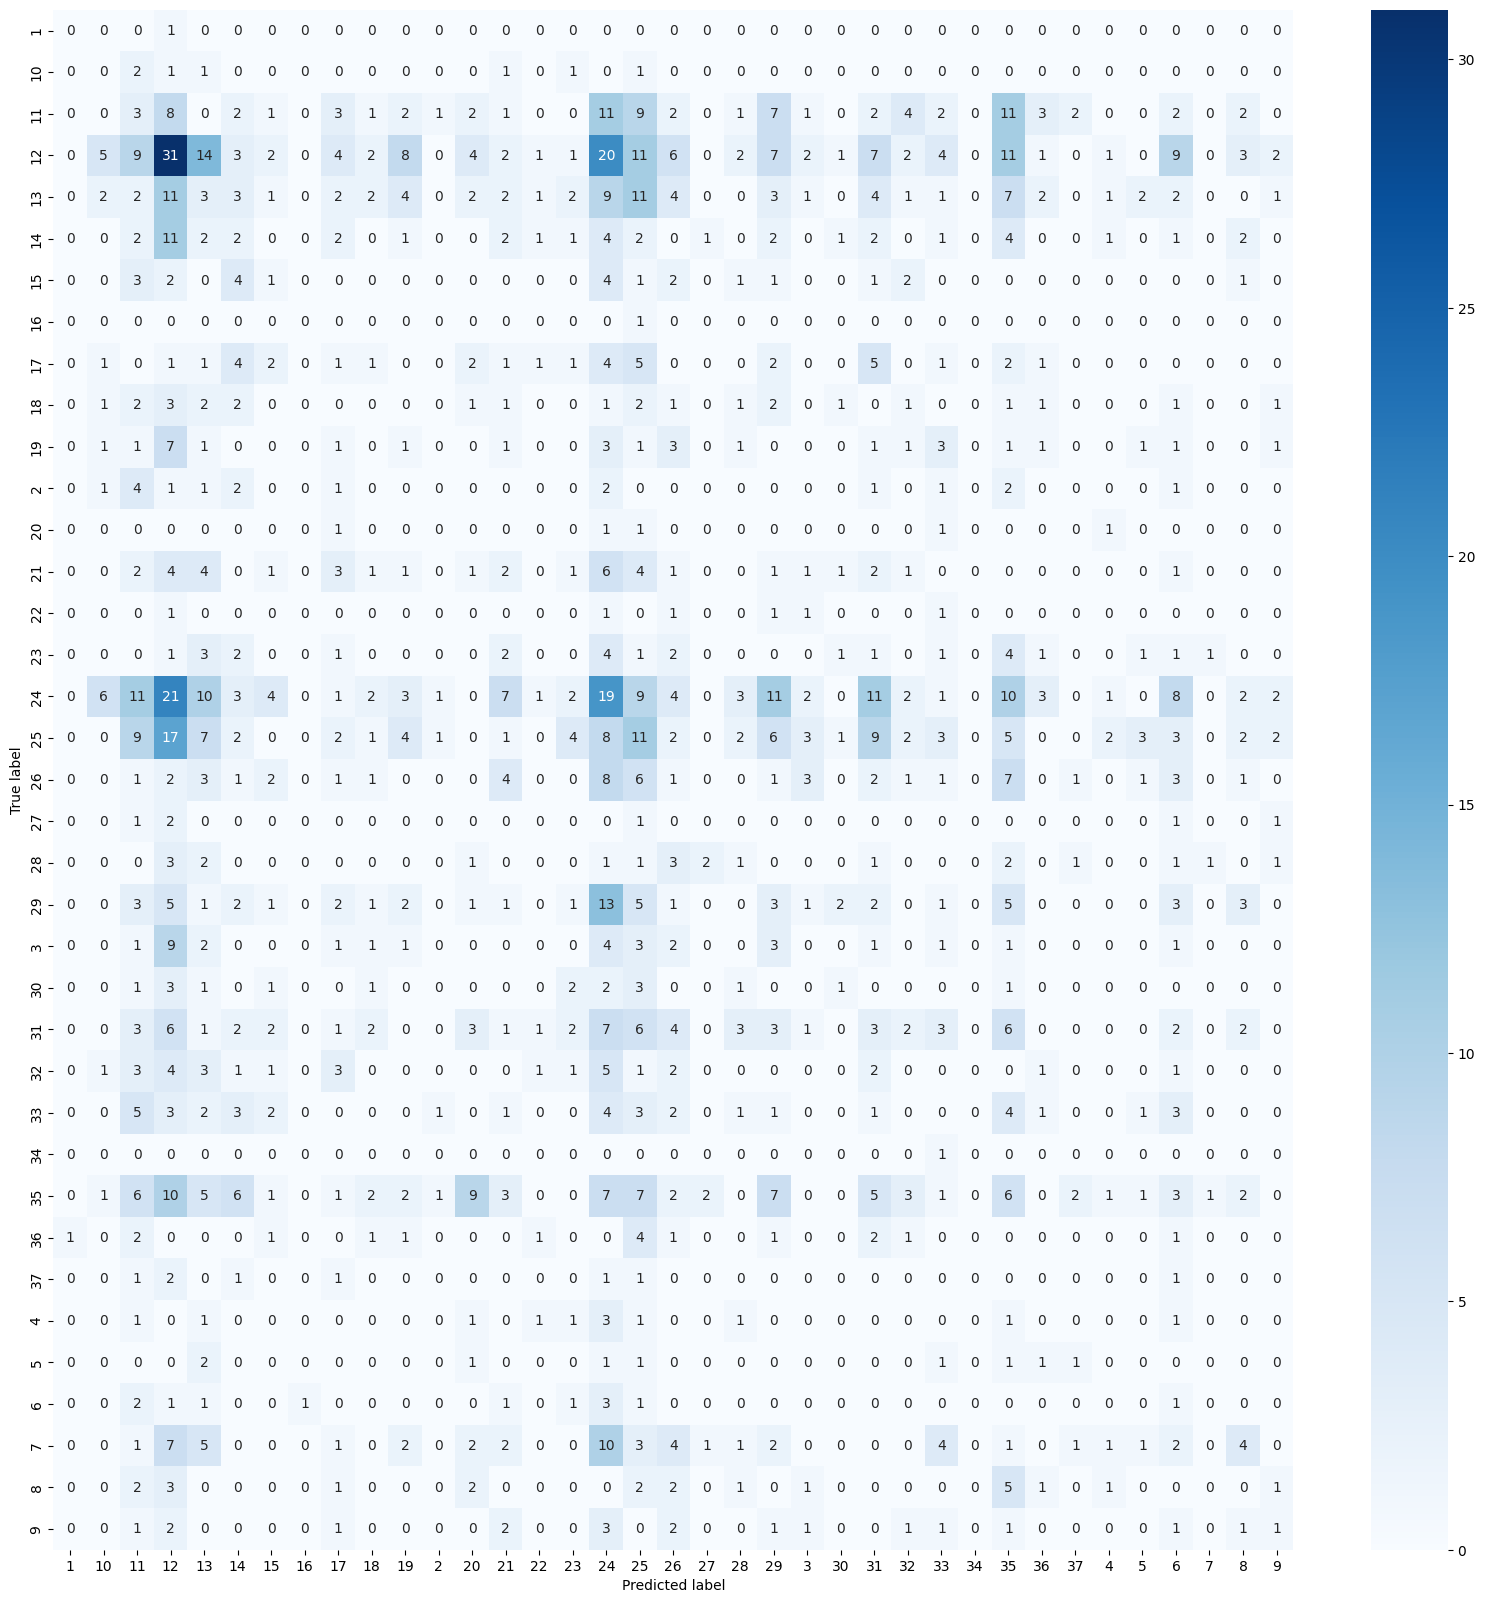

In [170]:
from sklearn.metrics import confusion_matrix
# Get predictions on test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Compute confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize = (20,20))
# plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
